In [1]:
library(tidyverse)
options(repr.plot.height=6, repr.plot.width=10)
theme_set(theme_classic())

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# STATS 504 
## Week 5: Solar weather and GOES data

## About the data source
- The Geostationary Operational Environmental Satellites (GOES) are a series of satellites in geostationary orbit.
- They collect:
    - [Terrestrial weather data](https://www.star.nesdis.noaa.gov/goes/) (cloud cover, storms, hurricanes, etc.)
    - Atmospheric observations (temperature, humidity, solar radiation)
    - [Space weather data](https://www.swpc.noaa.gov/products/goes-x-ray-flux) (our focus)

## Space weather
https://www.youtube.com/watch?v=oOXVZo7KikE

# Understanding GOES X-ray Flux Measurements

- There are two GOES measurements:
  - Flux1 (Short Channel): Captures higher-energy X-rays with shorter wavelengths (0.5–4.0 Å). Sensitive to more intense solar events.
  - Flux2 (Long Channel): Captures lower-energy X-rays with longer wavelengths (1.0–8.0 Å). Used to classify solar flares.
- The Flux2 measurement is primarily used for classifying the magnitude of solar flares (e.g., C-class, M-class, X-class) based on the peak flux level.
- The ratio of Flux1 to Flux2 can provide insights into the temperature and emission characteristics of the solar plasma during flare events.

## The raw data
(Importing in R turned out to be difficult so I [switched over to Python](prep.ipynb))

In [90]:
df <- arrow::read_feather("goes2018.feather")  # not posted to github, too large
summary(df)

      Year          Month             Day             Time         
 Min.   :2018   Min.   : 1.000   Min.   : 1.00   Min.   :   -2.05  
 1st Qu.:2018   1st Qu.: 4.000   1st Qu.: 8.00   1st Qu.:21542.25  
 Median :2018   Median : 6.000   Median :16.00   Median :43088.44  
 Mean   :2018   Mean   : 6.466   Mean   :15.61   Mean   :43143.58  
 3rd Qu.:2018   3rd Qu.: 9.000   3rd Qu.:23.00   3rd Qu.:64751.19  
 Max.   :2018   Max.   :12.000   Max.   :31.00   Max.   :86397.93  
   Sat               Flux1               Flux2           __index_level_0__
 go14:14982271   Min.   :0.000e+00   Min.   :0.000e+00   Min.   :    0    
 go15:15252668   1st Qu.:1.820e-08   1st Qu.:3.831e-09   1st Qu.:10459    
                 Median :2.935e-08   Median :1.468e-08   Median :20956    
                 Mean   :3.681e-08   Mean   :1.760e-08   Mean   :20968    
                 3rd Qu.:4.218e-08   3rd Qu.:3.087e-08   3rd Qu.:31454    
                 Max.   :8.348e-06   Max.   :2.014e-06   Max.   :42188    

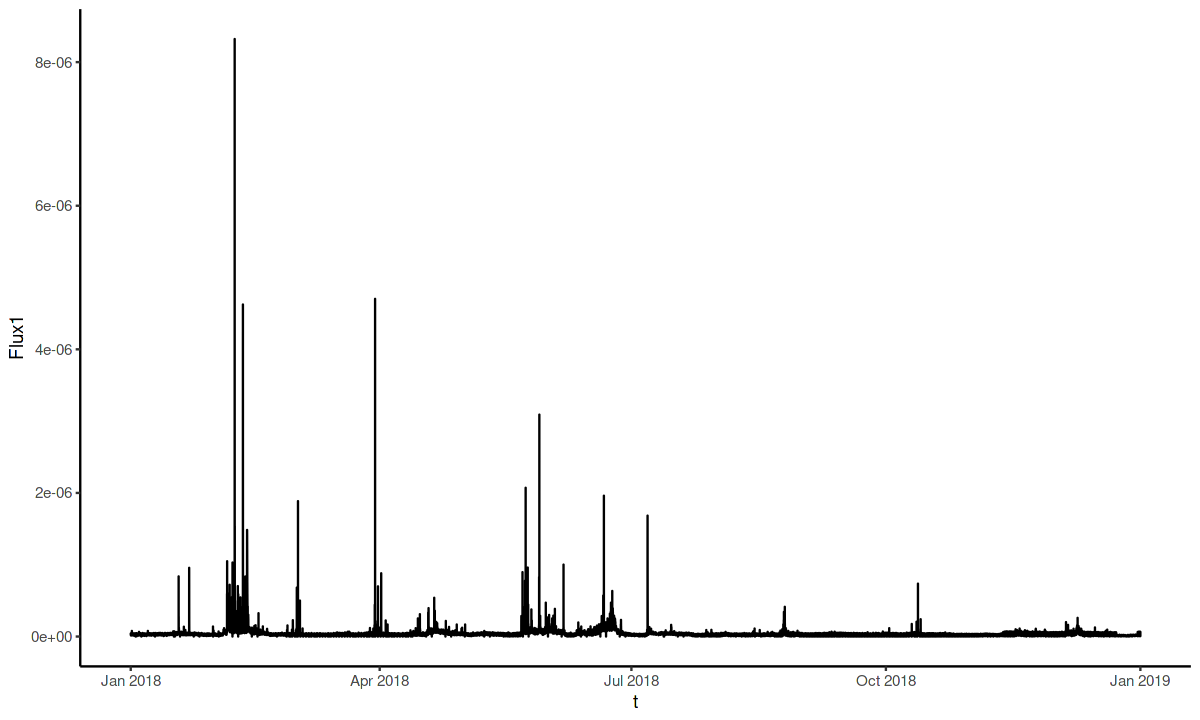

In [51]:
df %>% mutate(t = make_datetime(Year, Month, Day, 0, 0, 0), 
              t = t + dseconds(Time)) %>% 
    sample_frac(.01) %>% 
    ggplot + geom_line(aes(x = t, y = Flux1))

# (Too) big data
- We can already see that the data are very large and contain a lot of noise. This will make analysis complicated.
- We can effectively deal with both problems by averaging.


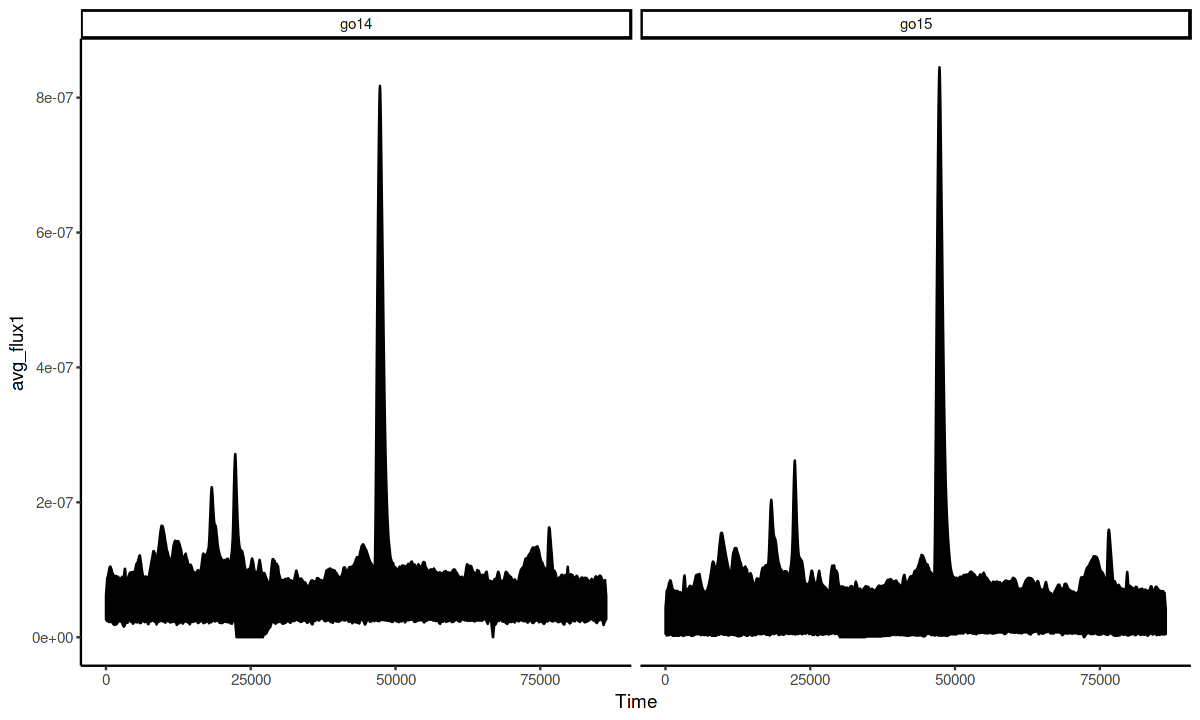

In [41]:
library(slider)

df %>% filter(Day == 1) %>% 
    arrange(Sat, Year, Month, Day, Time) %>% 
    group_by(Sat) %>% 
    mutate(avg_flux1 = slide_dbl(Flux1, mean, .before=1000, .after=1000)) %>% 
    ggplot + geom_line(aes(x=Time, y=avg_flux1)) + facet_grid(~ Sat)

## Daily averages
To get a very "high" level picture of the data, we can do the usual thing and summarize by each day:

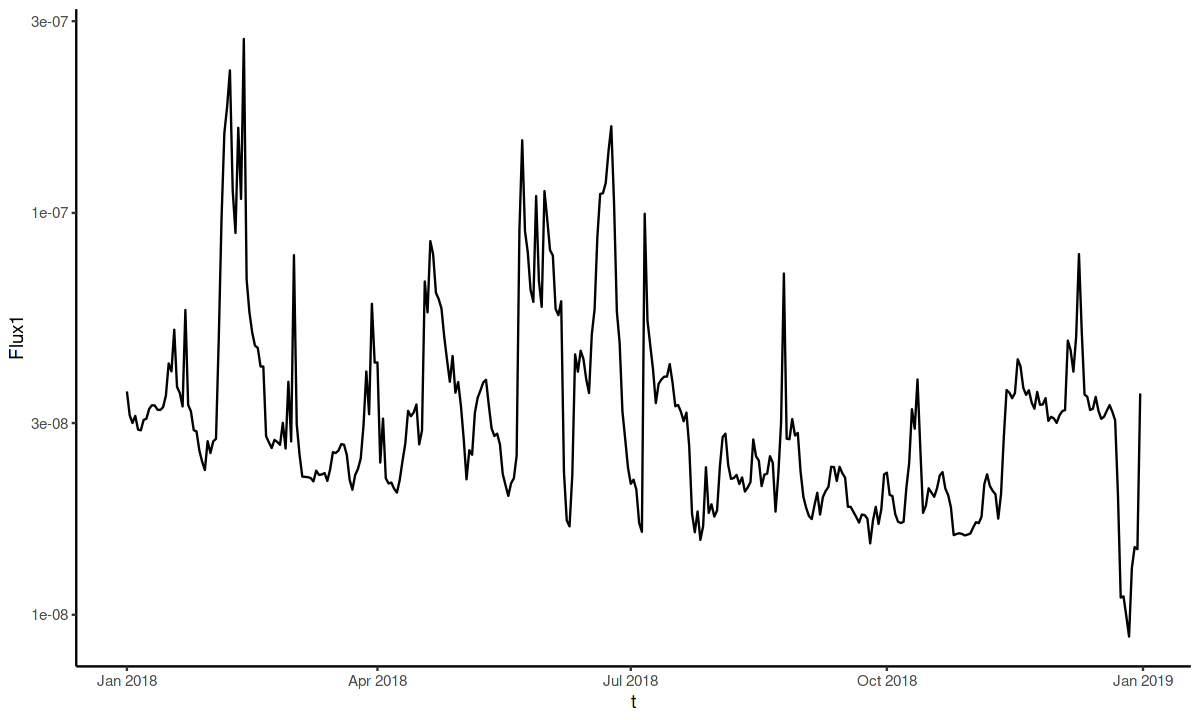

In [7]:
# a summarized view

For the rest of the lecture, we'll work with data summarized by daily average:

In [93]:
goes_daily <- arrow::read_feather('goes_daily.feather') %>% mutate(date = make_datetime(year, month, day))
save(goes_daily, file="goes_daily.RData")

In [94]:
# load(url('https://github.com/terhorst/stats504/raw/refs/heads/main/lectures/week5/goes_daily.RData'))
goes_daily %>% print

# A tibble: 21,546 × 7
    year month   day sat        flux1        flux2 date               
   <int> <int> <int> <fct>      <dbl>        <dbl> <dttm>             
 1  1980     1     4 go02  0.00000173 0.0000000238 1980-01-04 00:00:00
 2  1980     1     5 go02  0.00000169 0.0000000257 1980-01-05 00:00:00
 3  1980     1     6 go02  0.00000348 0.000000276  1980-01-06 00:00:00
 4  1980     1     7 go02  0.00000335 0.000000174  1980-01-07 00:00:00
 5  1980     1     8 go02  0.00000420 0.000000395  1980-01-08 00:00:00
 6  1980     1     9 go02  0.00000276 0.000000165  1980-01-09 00:00:00
 7  1980     1    10 go02  0.00000561 0.000000524  1980-01-10 00:00:00
 8  1980     1    11 go02  0.00000347 0.000000104  1980-01-11 00:00:00
 9  1980     1    12 go02  0.00000485 0.000000224  1980-01-12 00:00:00
10  1980     1    13 go02  0.00000531 0.000000356  1980-01-13 00:00:00
# ℹ 21,536 more rows


Warning message:
“Removed 221 rows containing missing values (`geom_point()`).”


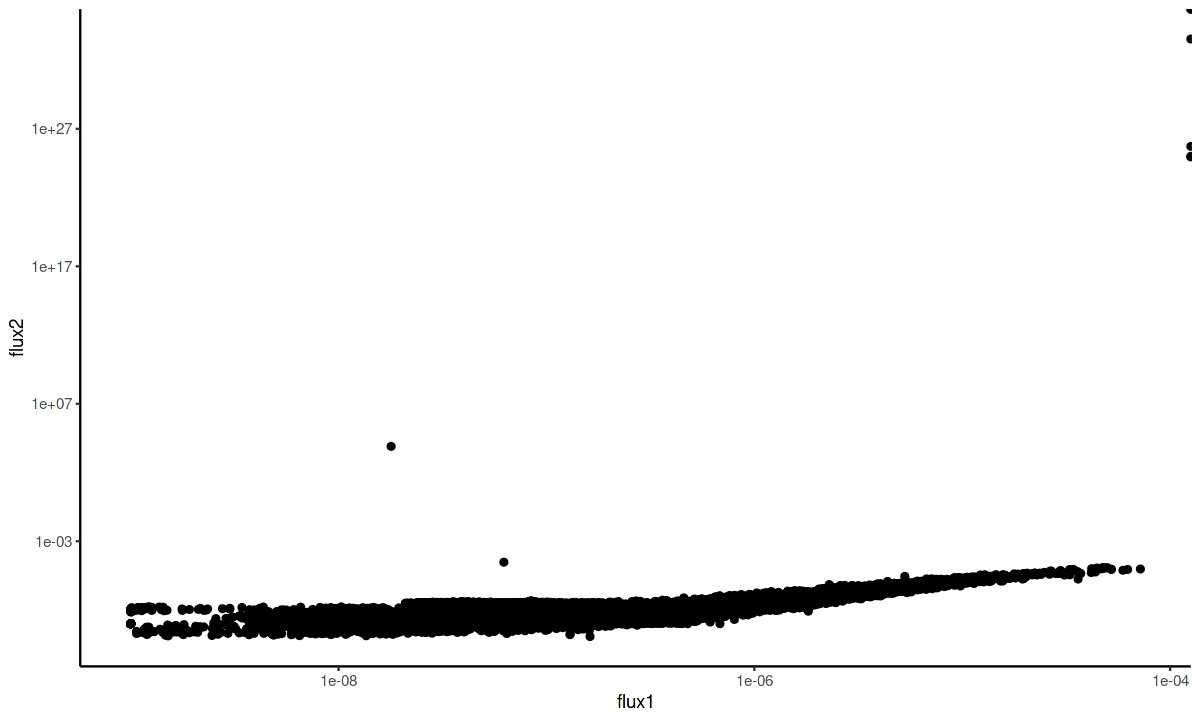

In [95]:
# The raw data
goes_daily %>% ggplot + geom_point(aes(x=flux1, y=flux2)) + scale_x_log10() + scale_y_log10()

# Some key questions
- Outliers?
- Missing data?
- What is the relationship between Flux1 and Flux2 (if any)?

In [97]:
goes_daily %>% pivot_longer(flux1:flux2) %>% print

# A tibble: 43,092 × 7
    year month   day sat   date                name         value
   <int> <int> <int> <fct> <dttm>              <chr>        <dbl>
 1  1980     1     4 go02  1980-01-04 00:00:00 flux1 0.00000173  
 2  1980     1     4 go02  1980-01-04 00:00:00 flux2 0.0000000238
 3  1980     1     5 go02  1980-01-05 00:00:00 flux1 0.00000169  
 4  1980     1     5 go02  1980-01-05 00:00:00 flux2 0.0000000257
 5  1980     1     6 go02  1980-01-06 00:00:00 flux1 0.00000348  
 6  1980     1     6 go02  1980-01-06 00:00:00 flux2 0.000000276 
 7  1980     1     7 go02  1980-01-07 00:00:00 flux1 0.00000335  
 8  1980     1     7 go02  1980-01-07 00:00:00 flux2 0.000000174 
 9  1980     1     8 go02  1980-01-08 00:00:00 flux1 0.00000420  
10  1980     1     8 go02  1980-01-08 00:00:00 flux2 0.000000395 
# ℹ 43,082 more rows


Warning message:
“Removed 63 rows containing missing values (`geom_line()`).”


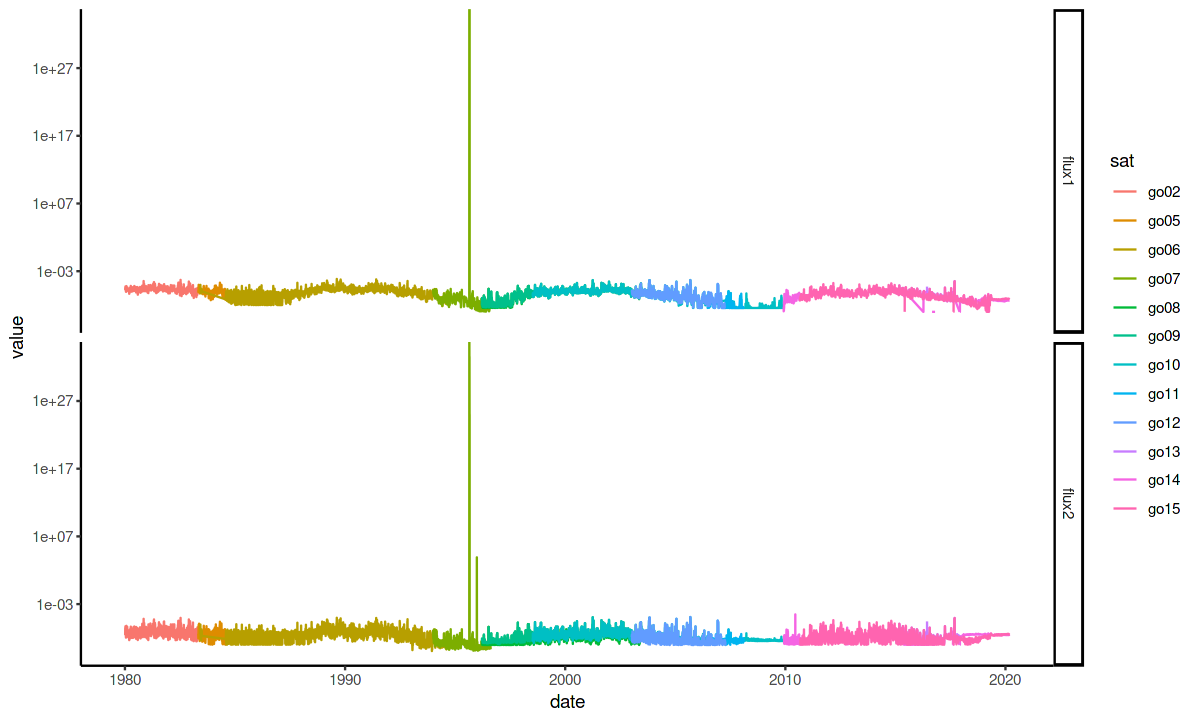

In [98]:
goes_daily %>% pivot_longer(flux1:flux2) %>% 
    ggplot() + 
    geom_line(aes(x = date, y = value, color = sat)) +
    scale_y_log10() + 
    facet_grid(name ~ .)

In [106]:
lm(flux2 ~ flux1, data = goes_daily) %>% summary

ERROR: Error in lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...): NA/NaN/Inf in 'x'


## What is the distribution of Flux? 
- What is the marginal distribution of Flux1/Flux2?
- What is their joint distribution?
- Are these distributions constant over time?
- How do `time`, `Sat` and `name` enter into the picture?

## Marginal distributions

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 450 rows containing non-finite values (`stat_bin()`).”


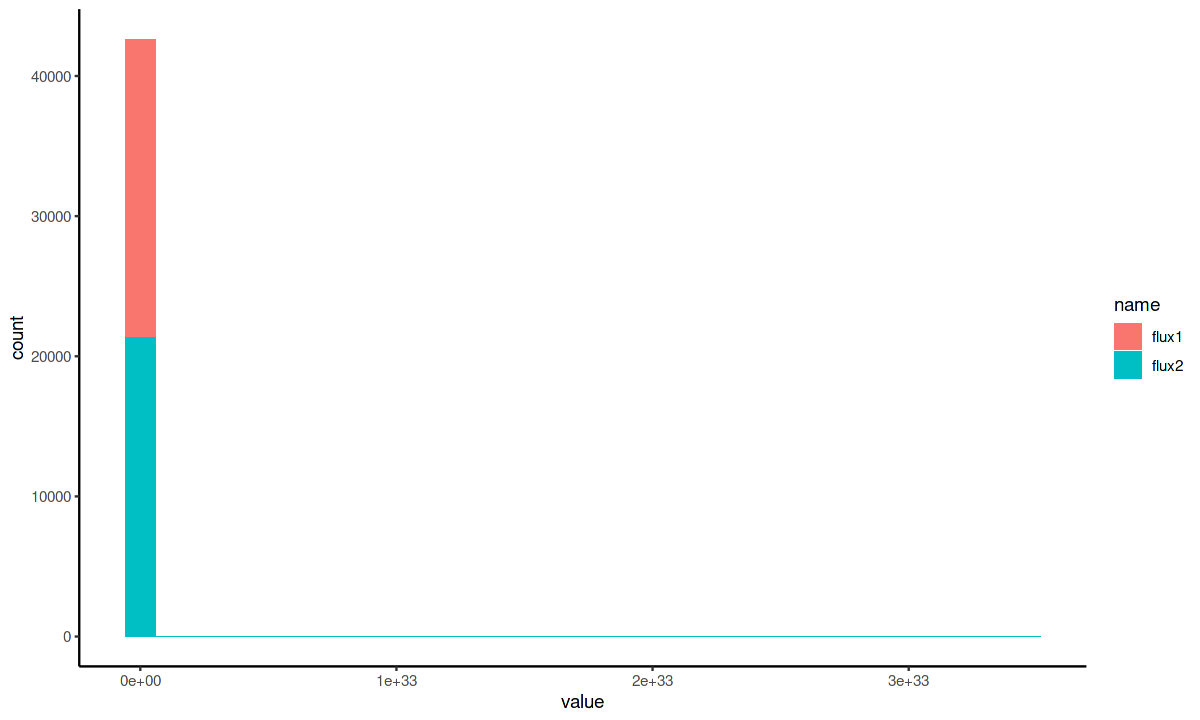

In [107]:
goes_daily %>% pivot_longer(flux1:flux2) %>% 
    ggplot() + geom_histogram(aes(x=value, fill=name))

## Joint distributions
How are `flux1` and `flux2` jointly distributed?

Warning message:
“Removed 227 rows containing non-finite values (`stat_density2d()`).”


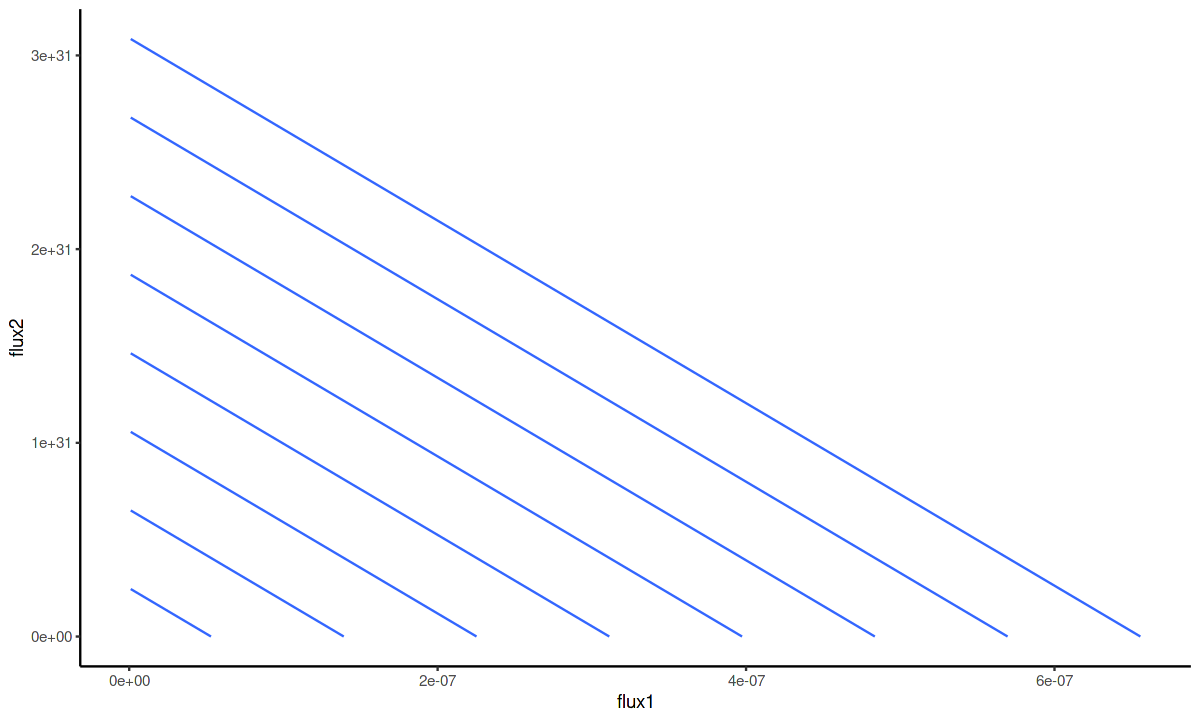

In [108]:
goes_daily %>% 
    ggplot + geom_density_2d(aes(x=flux1, y=flux2))

## Variation over time
Is the distribution of the data constant across time?

In [117]:
?na_if

`summarise()` has grouped output by 'year', 'month'. You can override using the `.groups` argument.


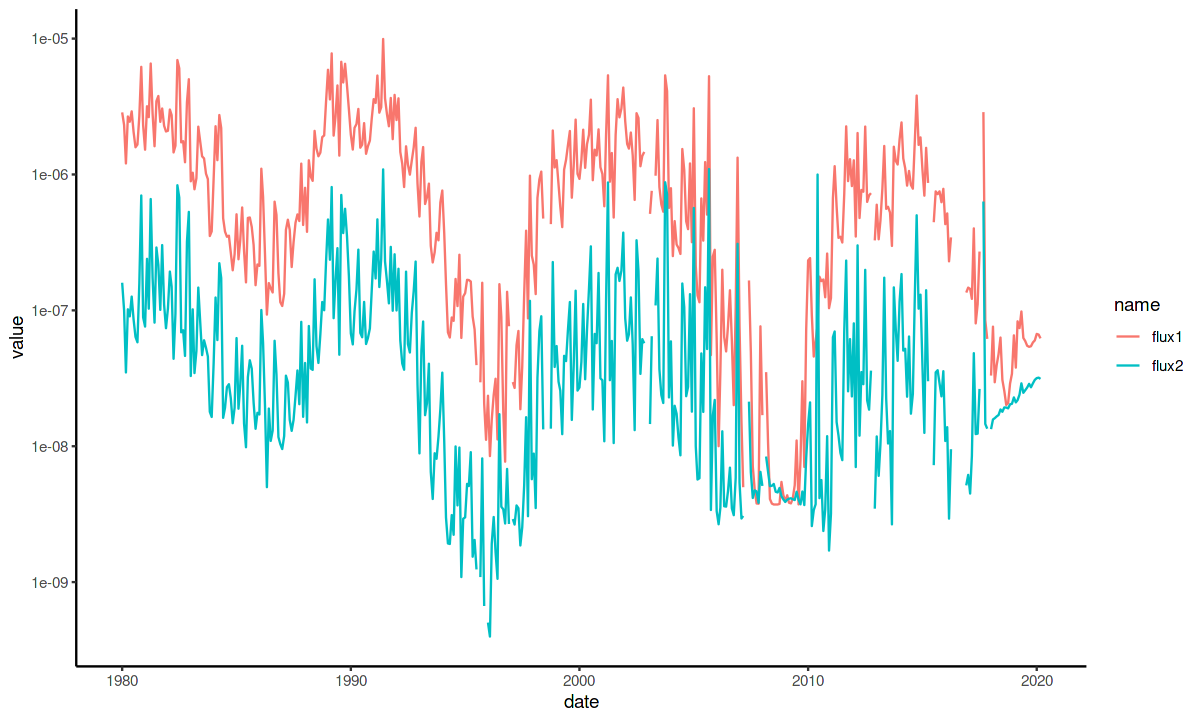

In [118]:
goes_daily %>% pivot_longer(flux1:flux2) %>% 
    mutate(value = ifelse(value > 1e-4, NA, value)) %>% 
    group_by(year, month, name) %>% summarize(value = mean(value)) %>%
    mutate(date = make_date(year, month)) %>% 
    ggplot + geom_line(aes(x = date, y = value, color = name)) +
    scale_y_log10()

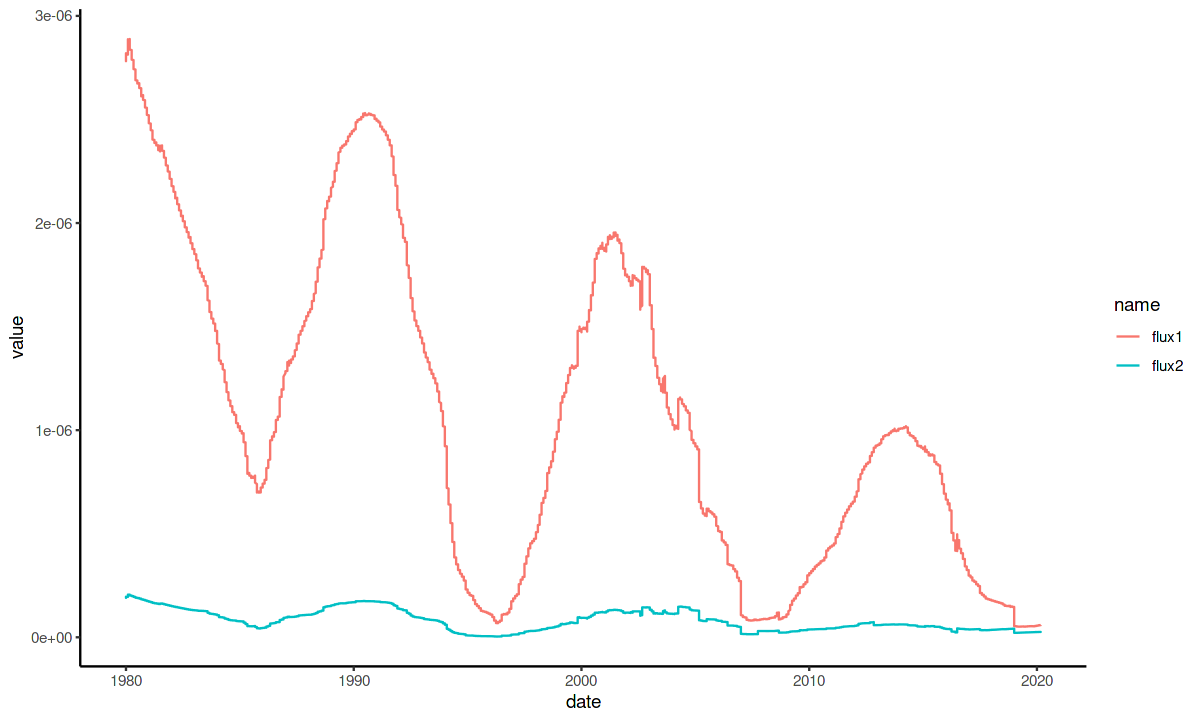

In [129]:
library(slider)

goes_daily %>% pivot_longer(flux1:flux2) %>% 
    group_by(name) %>% arrange(date) %>% 
    mutate(value = ifelse(value > 1e-4, NA, value)) %>% 
    mutate(value = slide_dbl(value, \(v) mean(v, na.rm=T), .before=1000, .after=1000)) %>% 
    mutate(date = make_date(year, month)) %>% 
    ggplot + geom_line(aes(x = date, y = value, color = name))

# Periodicity

- Time series data are often periodic.
- A periodogram is a tool used in time series analysis to identify the dominant frequencies or periodicities present in the data.
- To compute and plot the periodogram of a time series in R, use the built-in `spec.pgram`:

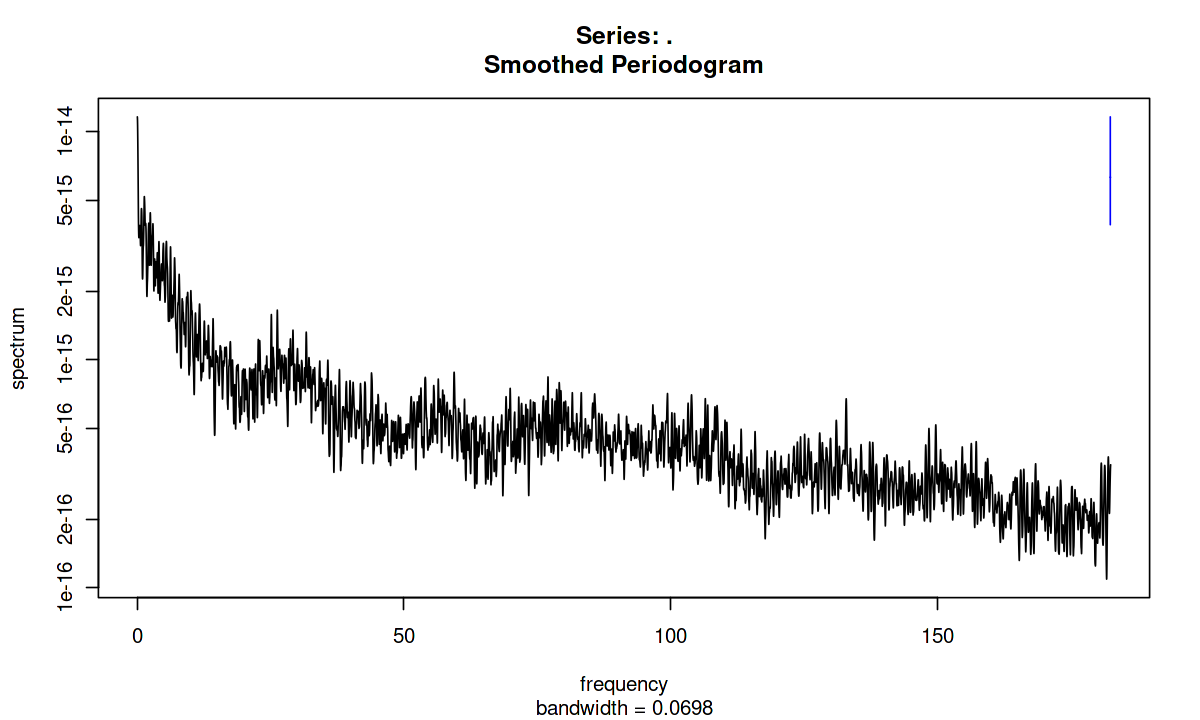

In [178]:
library(slider)

goes_daily %>% pivot_longer(flux1:flux2) %>% 
    group_by(name) %>% arrange(date) %>% 
    mutate(value = ifelse(value > 1e-4, NA, value)) %>% 
    drop_na %>% 
    filter(name == "flux2") -> temp

ts(temp$value, frequency=365) %>% spec.pgram(spans=c(10, 10), detrend=T, demean=T)

## Time series analysis
In this lecture we will do more time series analysis. To make things easier, we'll need rely
on some nice libraries in R:

In [240]:
library(tsibble)
library(feasts)
library(fable)

First we will convert the dataset to a special kind of tibble that understands time series operations:

In [6]:
library(tsibble)

goes_daily %>% mutate(date = make_date(year, month, day)) %>% 
    as_tsibble(index=date, key=sat) %>% 
    ungroup ->
    goes_daily_ts

goes_daily_ts %>% print


Attaching package: ‘tsibble’


The following object is masked from ‘package:lubridate’:

    interval


The following objects are masked from ‘package:base’:

    intersect, setdiff, union




ERROR: Error in mutate(., date = make_date(year, month, day)): object 'goes_daily' not found


In [242]:
print(goes_daily_ts)

# A tsibble: 8,825 x 7 [1D]
# Key:       sat [6]
    year month   day sat          flux1         flux2 date      
   <int> <int> <int> <fct>        <dbl>         <dbl> <date>    
 1  2005     1     1 go10  0.00000235   0.000000478   2005-01-01
 2  2005     1     2 go10  0.000000411  0.0000000220  2005-01-02
 3  2005     1     3 go10  0.000000398  0.0000000218  2005-01-03
 4  2005     1     4 go10  0.000000374  0.0000000266  2005-01-04
 5  2005     1     5 go10  0.000000127  0.0000000119  2005-01-05
 6  2005     1     6 go10  0.0000000489 0.00000000598 2005-01-06
 7  2005     1     7 go10  0.0000000780 0.00000000653 2005-01-07
 8  2005     1     8 go10  0.000000140  0.00000000597 2005-01-08
 9  2005     1     9 go10  0.00000103   0.0000000837  2005-01-09
10  2005     1    10 go10  0.0000000976 0.00000000355 2005-01-10
# ℹ 8,815 more rows


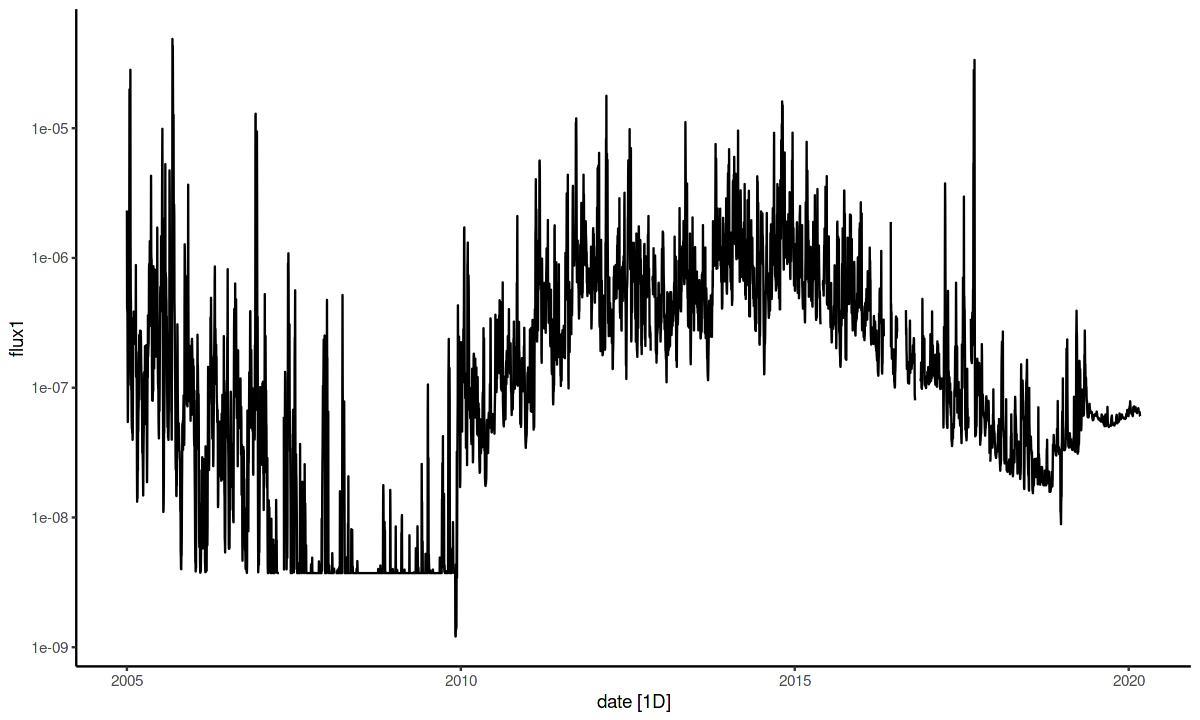

In [335]:
goes_daily_ts1 %>% autoplot(flux1) + scale_y_log10()

To make things a bit simpler I will combined the data from each satellite into a single daily average:

In [325]:
goes_daily_ts %>% index_by(date) %>% 
    summarize(across(flux1:flux2, mean)) -> goes_daily_ts1

goes_daily_ts1

date,flux1,flux2
<date>,<dbl>,<dbl>
2005-01-01,2.322763e-06,4.807203e-07
2005-01-02,4.118884e-07,1.955416e-08
2005-01-03,3.971638e-07,1.906986e-08
2005-01-04,3.723984e-07,2.424830e-08
2005-01-05,1.297508e-07,9.258739e-09
2005-01-06,5.442822e-08,3.840782e-09
2005-01-07,8.413164e-08,4.300927e-09
2005-01-08,1.472872e-07,4.712758e-09
2005-01-09,1.041388e-06,8.404922e-08


## Quiz 🤷  
Sometime in 2012 there was an [X-class solar flare](https://svs.gsfc.nasa.gov/10109/) event. When did it happen?

In [202]:
# 2012 solar flare?

## Quiz 🤷  
Solar activity is on an [approximately 11-year cycle](https://en.wikipedia.org/wiki/Solar_cycle). Can we see this in the X-Ray data? When do you think was the last solar maximum?

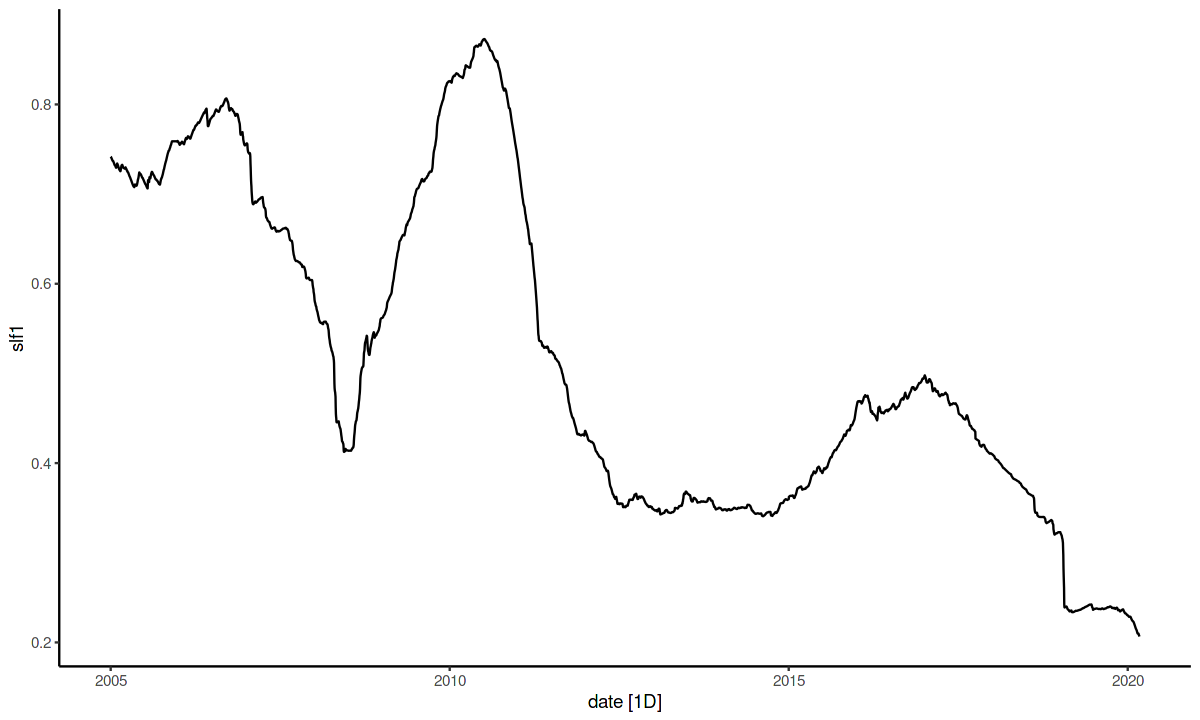

In [356]:
# solar activity

library(slider)

goes_daily_ts1 %>% mutate(slf1 = slide_dbl(log10(flux1), 
                                           \(x) sd(x, na.rm=T),
                                           .before=500, .after=500)) %>% 
    autoplot(slf1)

## Quiz 🤷
How does the *variance* in solar output compare for the current solar cycle ([S24](https://en.wikipedia.org/wiki/Solar_cycle_24_)) versus the last ([S23](https://en.wikipedia.org/wiki/Solar_cycle_23))? (Note: we only have partial data on S23 in this table.)

In [300]:
# variance in solar output

## Decomposing the solar cycle
Can we learn from data that the solar cycle is ~11 years long?

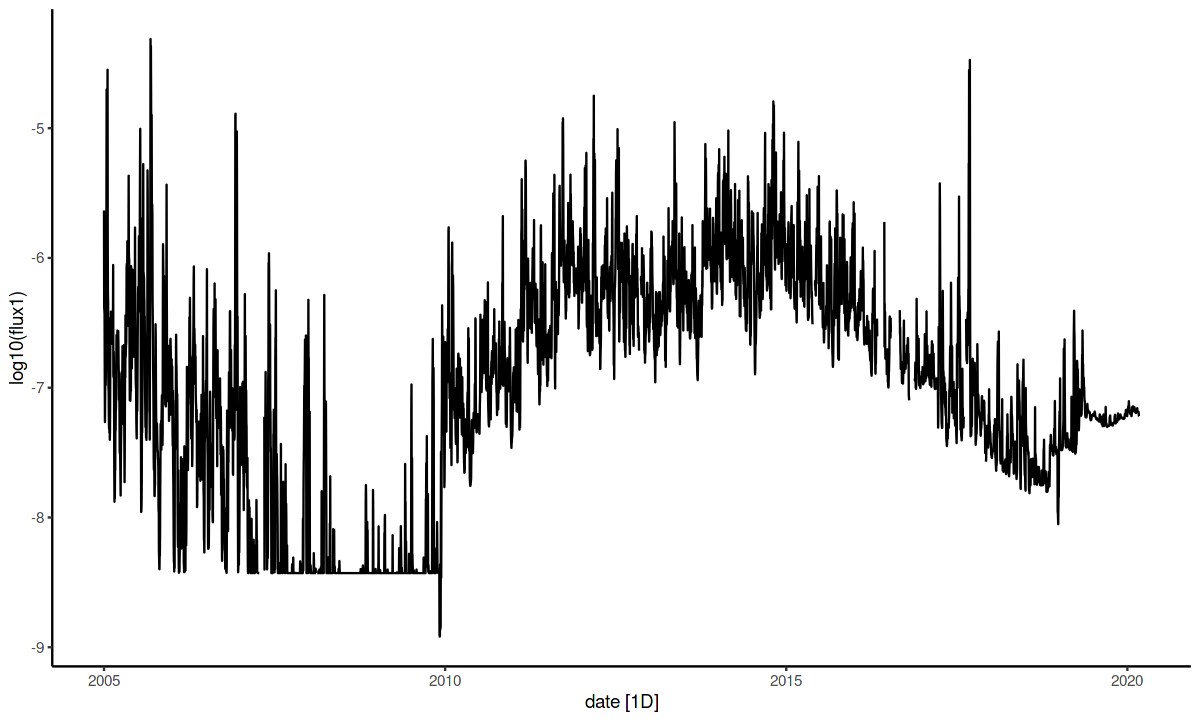

In [357]:
goes_daily_ts1 %>% autoplot(log10(flux1))

In [376]:
goes_daily_ts1 %>% 
    fill_gaps %>% 
    fill(flux1, flux2) %>% 
    filter(year(date) == 2005, month(date) == 11, day(date) == 16)

date,flux1,flux2
<date>,<dbl>,<dbl>
2005-11-16,6.764132e-07,4.619255e-08


In [377]:
smooth_goes <- function(k) {
    goes_daily_ts1 %>%
        fill_gaps %>% 
        fill(flux1) %>% 
        mutate(slf1 = slide_dbl(log10(flux1), \(x) mean(x, na.rm=T), .before=k, .after=k))
}

[1] 4015

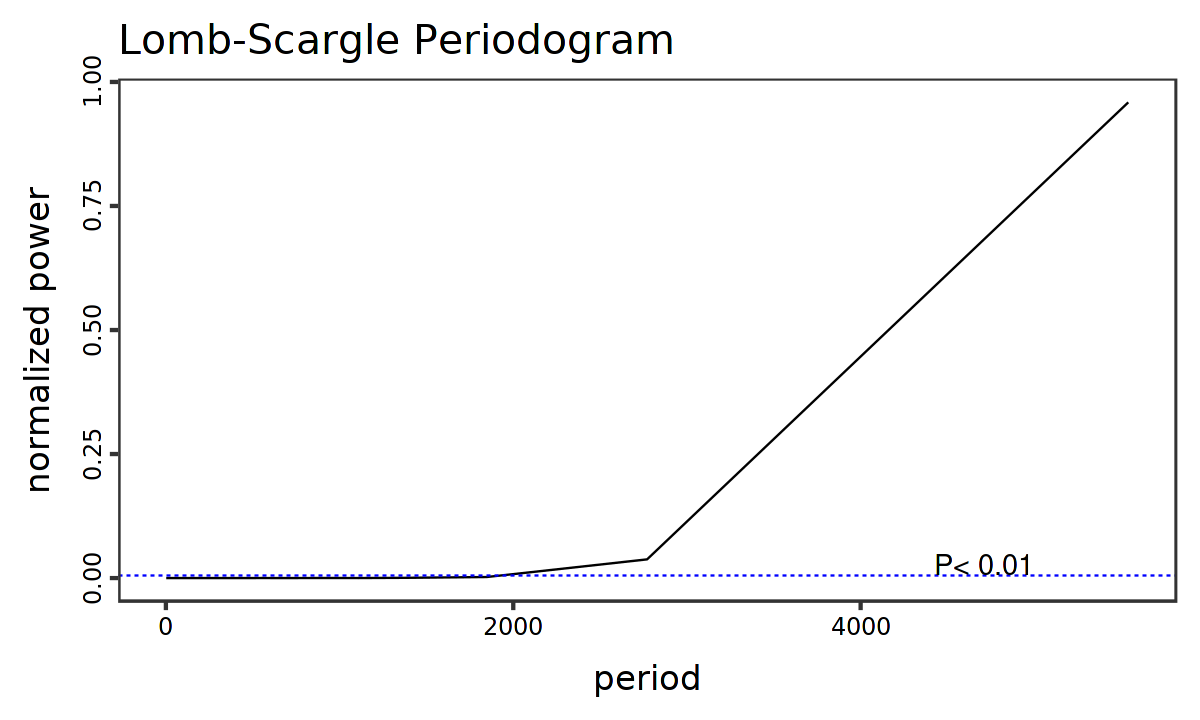

In [390]:
library(slider)
smooth_goes(1000) %>% pluck('slf1') %>% lsp(type = "period")

11 * 365

## Other types of decompositions

There are some well-known decompositions that analysts often apply to time-series data. We'll look at two:
- Classical decomposition
- STL

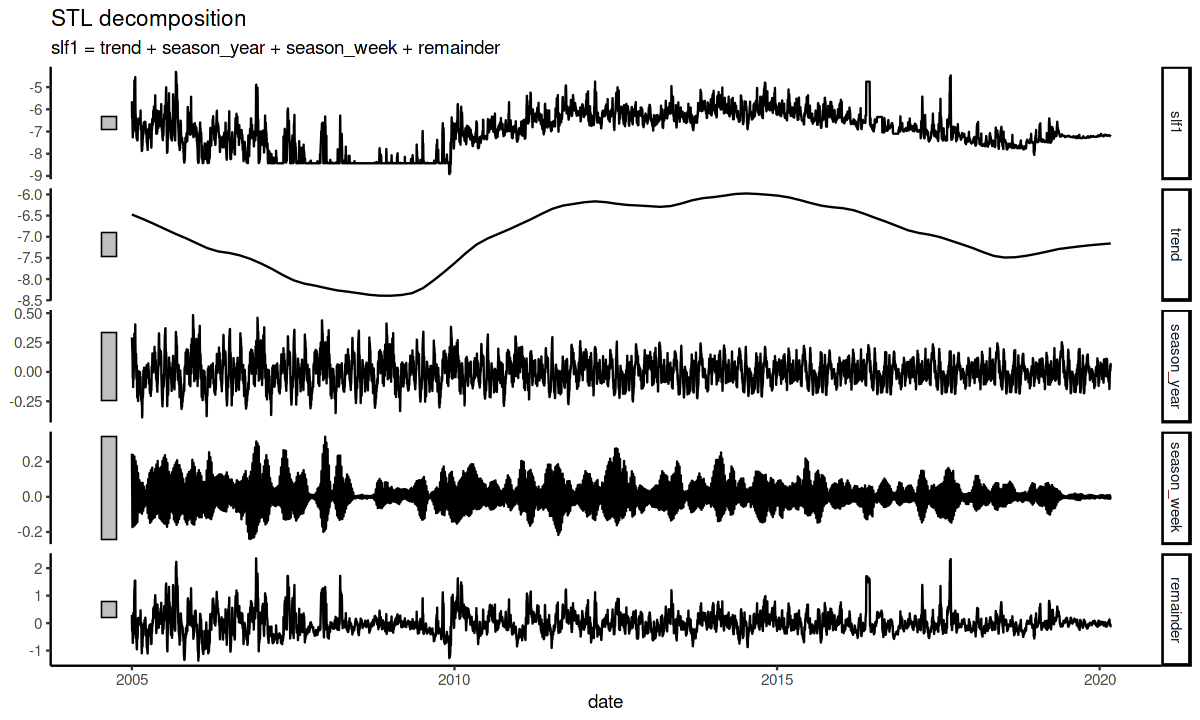

In [401]:
smooth_goes(0) %>% model(STL(slf1))  %>% 
    components %>% autoplot

## STL decomposition
STL decomposes the time series into *s*easonal and *t*rend (using a *L*OESS smoother).

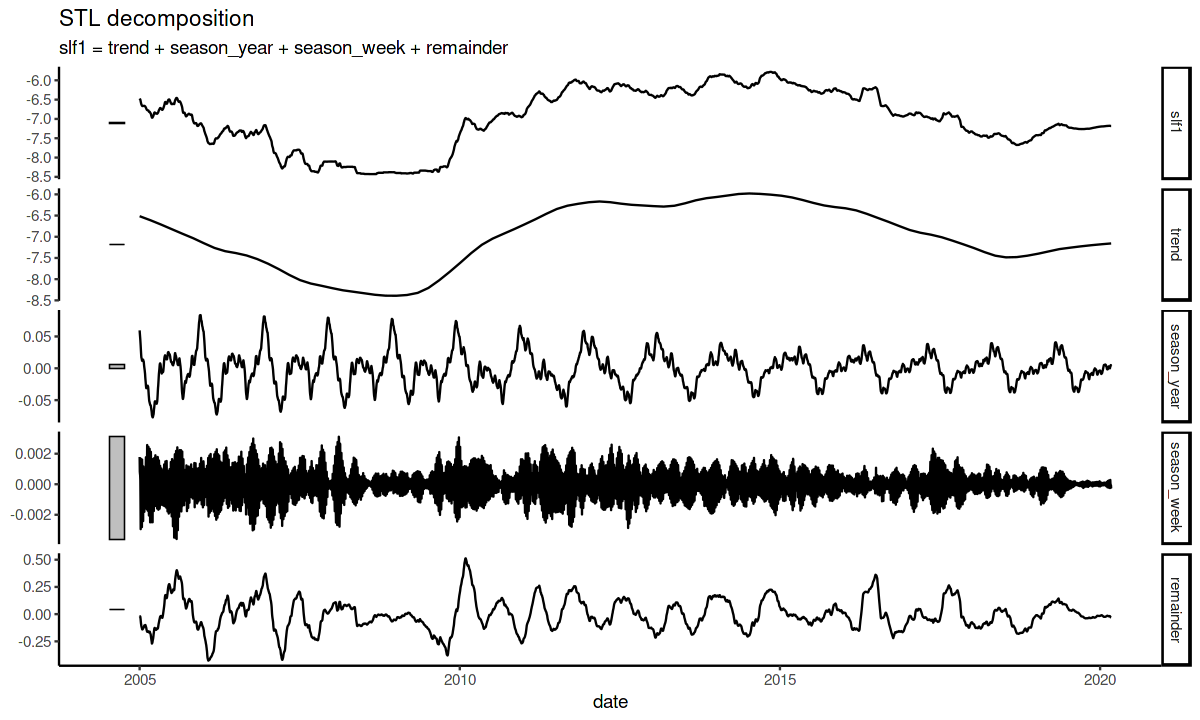

In [281]:
smooth_goes(50) %>% model(STL(slf1)) %>% 
    components %>% autoplot

## Autocorrelations
An autocorrelation plot shows the amount of correlation between a time series and its lags. It can be used to diagnose whether there are seasonal or trend components, since:
- When data have a trend, the correlations for small lags tend to be large and positive (why?) => AFC will have positive values that slowly decrease with lag length.
- When data are seasonal, the autocorrelations will be larger at multiples of the seasonal period.

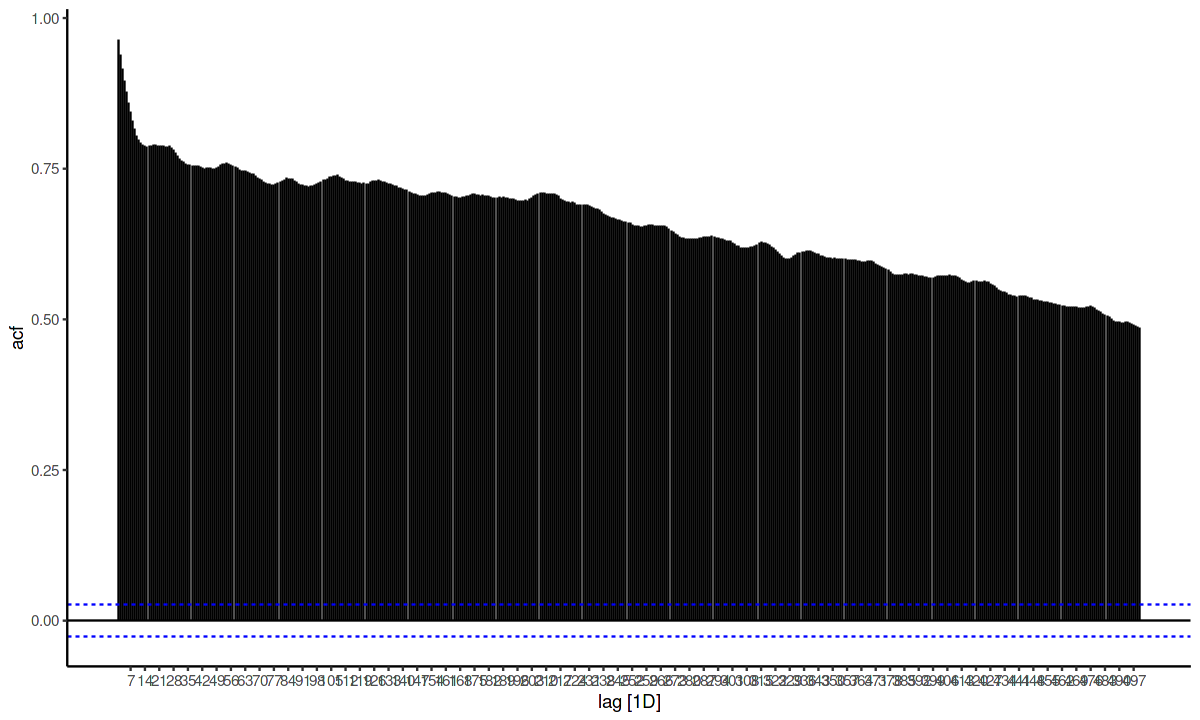

In [405]:
smooth_goes(0) %>% ACF(slf1, lag_max=500) %>% autoplot

## The Hurst coefficient
The [Hurst exponent](https://en.wikipedia.org/wiki/Hurst_exponent) $H$ measures how much "memory" a time series has:

- $H\in[0.5,1]$ indicates a time series with long-term positive autocorrelation: a high value tends to be followed by another high value and that future excursions to more high values do occur. 
- $H\in[0,0.5]$ indicates a time series with long-term switching between high and low values in adjacent pairs, meaning that a single high value will probably be followed by a low value and that the value after that will tend to be high
- A value of $H\approx 0.5$ indicates short-memory, with (absolute) autocorrelations decaying exponentially quickly to zero.

In [410]:
smooth_goes(1000) %>% features(flux1, coef_hurst)

coef_hurst
<dbl>
0.9384903


In [306]:
 %>% features(slf1, coef_hurst)

coef_hurst
<dbl>
0.99986
